### Proximal policy optimization

PPO [1] is trying to combine the two objectives into one: first that $\frac{\pi_\theta(a|s)}{\pi_{\theta_k}(a|s)}A^{\pi_{\theta_k}}$ is maximized and secondly that the policy does not go far from the original policy in the action distribution space by not encouraging it (clipping)

Having collected experience $D_k$ from policy $\pi_k$, compute rewards-to-go $\hat{R}$ and advantage estimates $A=Q(s,a)-V(s,a)=r_t+\gamma v_{t+1}-v_t$ using value estimates.

Next, update $\theta$ using Adam steps until $D_{KL}(\theta|\theta_k)>\delta$ on objective

$$
L_1(\theta)=\frac{1}{|D|}\sum\limits_{\tau\in D_k}\sum\limits_{t=0}^{T_\tau}\min\left(\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_k}(a_t|s_t)}A^{\pi_k}(s_t,a_t),g(\varepsilon,A^{\pi_k}(s_t,a_t))\right)
$$

Using a constraint $J_C+g_C(\theta-\theta_0)\leq С_{\max}$ with projection after each step

with $g(\varepsilon, A)=\begin{cases}
(1+\varepsilon)A,&A\geq 0\\
(1-\varepsilon)A,&A< 0\\
\end{cases}$

and on 
$$
L_2(\varphi)=\frac{1}{|D|}\sum\limits_{\tau\in D_k}\sum\limits_{t=0}^{T_\tau}(V_\varphi(s_t)-\hat{R}_t)^2
$$


[1] https://spinningup.openai.com/en/latest/algorithms/ppo.html

In [1]:
from sppo import *
from baselines import *
from tf_helpers import *
from saferl import *
from test_agents import *
from tqdm import tqdm
%matplotlib inline
from matplotlib import pyplot as plt

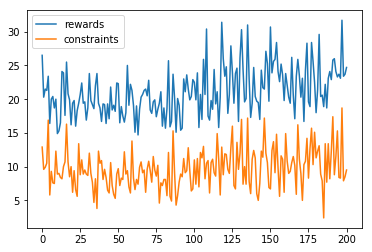

 28%|██▊       | 277/1000 [00:21<01:23,  8.66it/s]

In [ ]:
test_convergence_unsafe()

True

In [42]:
env.reset()

In [40]:
# importing tensorflow
import tensorflow as tf

# import scipy
import scipy, csv

import pandas as pd

In [41]:
import gym
from gym import wrappers
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

In [57]:
def get_rollout():
    """ Obtain rollout using policy """
    done = False
    observation = env.reset()
    sarc = []
    while not done:
        act = sample_action(observation)
        observation_, reward, done, info = env.step(act) # take a random action
        c = cost(observation)
        sarc.append((observation, act, reward, c))
        observation = observation_
    env.close()
    return sarc

Want: $(\theta_1+\Delta\theta-\theta_0)^T g_C\leq C_{\max}$ which gives $\Delta\theta^T g_C\leq C_{\max}-J_C+(\theta_0-\theta_1)^T g_C=R$. In case if $R>0$, no action required. Otherwise $\Delta\theta=g_CR/\|g_C\|^2$

In [83]:
def train_step(C_max_ = 10):
    # obtaining rollout data
    S, A, R, C = list(zip(*get_rollout()))
    sess.run(step, feed_dict = {states: S, actions: A, rewards: R, discounted_rewards_to_go: discount(R),
                               C_max: C_max_, disc_costs: discount(C)
                               })
    return np.sum(R), np.sum(C)

In [84]:
C_max_ = 50

In [85]:
RtoC

[<tf.Tensor 'concat_12:0' shape=(196,) dtype=float64>,
 <tf.Tensor 'concat_13:0' shape=(196,) dtype=float64>]

In [114]:
init = tf.global_variables_initializer()
sess.run(init)

S, A, R, C = list(zip(*get_rollout()))

sess.run([L1,L2, R_clipped, RtoC], feed_dict = {states: S, actions: A, rewards: R, discounted_rewards_to_go: discount(R),
                                         C_max: C_max_, disc_costs: discount(C)})

[-1.0001018397522465, 57.01784342366818, -0.0, 0.920143060498261]

In [34]:
np.sum(gamma_discount ** np.arange(200))

200

In [35]:
init = tf.global_variables_initializer()
sess.run(init)
r = []
c = []

In [36]:
for i in tqdm(range(10000)):
    r_, c_ = train_step(C_max_ = C_max_)
    r.append(r_)
    c.append(c_)

100%|██████████| 10000/10000 [02:13<00:00, 74.83it/s]


1. Slow convergence. Try to increase step size if $\cos (g_R, g_C)$ is approximately $1$? Measure it and check!
2. Estimate $g_C$ over many episodes to get a more reliable constraint

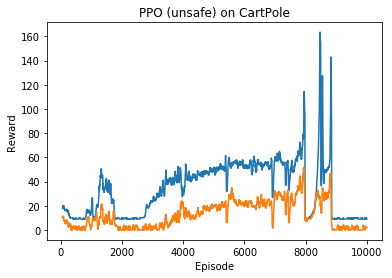

In [37]:
plt.figure()
plt.title('PPO (unsafe) on CartPole')
plt.plot(pd.DataFrame(r).rolling(50).median(), label = 'reward')
plt.plot(pd.DataFrame(c).rolling(50).median(), label = 'cost')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.savefig('sppo.eps', bbox_inches = 'tight')
plt.show()

In [24]:
env = env.unwrapped

In [ ]:
env = gym.wrappers.Monitor(env, './video')
get_rollout()

In [167]:
sess.run(params)

[array([[-0.83253563, -0.68914142, -0.06116719, -0.27323933, -0.5213027 ,
          0.6985349 , -0.64544735,  0.67992079,  0.67211518,  0.17009102],
        [ 0.00793548,  0.66713229,  0.32365717,  0.234717  , -0.25280851,
          0.51593658,  0.35389711, -0.16864096,  0.33962425,  0.00958664],
        [-1.07954104,  0.4448296 ,  0.32367536,  0.01020328,  0.39434612,
          0.26840221,  0.56831521, -0.14168297,  0.32801972,  0.3746401 ],
        [ 0.52174677, -0.66664846, -0.19249984,  0.6350071 , -0.15556228,
          0.54627296,  0.13961452, -0.73726243, -0.16869851, -0.54223824]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[ 0.17059255,  0.11023526,  0.05485238, -0.14846177,  0.63232917,
          0.11522713,  0.04685403, -0.21654478, -0.27550427, -0.05408931],
        [ 0.19957154,  0.05957377, -0.30506767, -0.42670896, -0.16968158,
          0.20515383, -0.00418471,  0.16230165, -0.10987148,  0.37591077],
        [-0.71681118, -0.22760498,  0.04497749,  0.134

In [27]:
tf.train.Saver().save(sess, './cartpole-h1.ckpt')

'./cartpole-h1.ckpt'

In [28]:
tf.train.Saver().restore(sess, './cartpole-h1.ckpt')

INFO:tensorflow:Restoring parameters from ./cartpole-h1.ckpt
